In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from simsimpy import *
import random

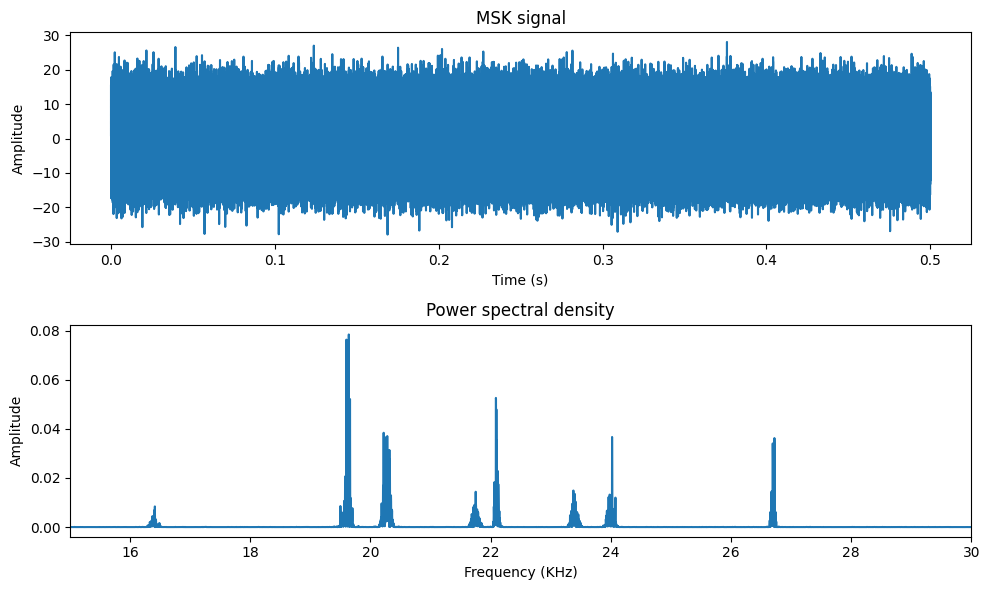

In [2]:
carriers = np.array([16.40e3, 19.60e3, 20.27e3, 21.75e3, 22.10e3, 23.40e3, 24.00e3, 26.70e3])
#carriers = np.array([16.0e3, 19.0e3, 20.e3, 21.e3, 22.e3, 23.e3, 24.00e3, 26.0e3])
baudrate = np.array([200,     200,     200,     200,     100,     200,     200,     100])
T_symbols = 1/baudrate
fs = 4e6
time = 0.5#2

t = np.linspace(0, time, int(fs*time))

# Generate the signal
msk_data_single = np.zeros((len(carriers), len(t)))
msk_data = np.zeros_like(t)
offset = np.zeros_like(carriers)
phase_offset = np.zeros_like(carriers)
amplitude = np.zeros_like(carriers)
data_true = np.zeros((len(carriers),int(time/T_symbols[0])))
phase = np.zeros((len(carriers),len(t)))
for i, (carrier, T) in enumerate(zip(carriers, T_symbols)):    
    offset[i] = random.uniform(-T_symbols[i]/2, T_symbols[i]/2)
    phase_offset[i] = random.uniform(-np.pi, np.pi)
    amplitude[i] = random.uniform(0.5, 2)
    msk_data_single[i], _, data_temp, phase[i] = generate_msk(int(time/T), 0.5, T, carrier, fs, offset=offset[i], phase_offset=phase_offset[i], amplitude=amplitude[i])
    msk_data += msk_data_single[i]
    data_true[i,0:int(time/T)] = data_temp[0:int(time/T)]
# Add noise
msk_data += np.random.normal(0, 5, msk_data.shape)

# calculate fft
#f, fft_msk_data = signal.periodogram(msk_data, fs, nfft=len(msk_data))
f, fft_msk_data = signal.welch(msk_data, fs, nperseg=len(msk_data))


fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot(t, msk_data)
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('MSK signal')


axs[1].plot(f/1e3, fft_msk_data)#10*np.log10(Pxx))
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Frequency (KHz)')
axs[1].set_title('Power spectral density')
axs[1].set_xlim(15, 30)
plt.tight_layout()




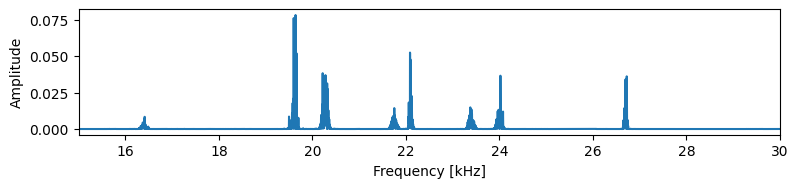

In [3]:
fig, ax = plt.subplots(figsize=(8, 2))

ax.plot(f/1e3, fft_msk_data)
ax.set_ylabel('Amplitude')
ax.set_xlabel('Frequency [kHz]')
ax.set_xlim(15, 30)
plt.tight_layout()
#plt.savefig('figures/analysis/msk_simulation.pdf')

# downconversion

In [4]:

msk_data_down = np.zeros((len(carriers), len(t)), dtype=complex)
for i, (carrier, T) in enumerate(zip(carriers, T_symbols)):
    msk_data_down[i] = msk_data*np.exp(-1j*2*np.pi*carrier*t)


# calculate fft
fft_msk_data_down = np.zeros((len(carriers), len(t)), dtype=complex)
for i in range(len(carriers)):
    f, fft_msk_data_down[i] = signal.periodogram(msk_data_down[i], fs, nfft=len(msk_data_down[i]))

#f, fft_msk_data_down = signal.periodogram(msk_data_down, fs, nfft=len(msk_data_down))

'''
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot(t, msk_data_down[2].real, label='real')
axs[0].plot(t, msk_data_down[2].imag, label='imag')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('MSK signal downconverted')
axs[0].legend()

axs[1].plot(f, fft_msk_data_down[2])#10*np.log10(Pxx))
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_title('Power spectral density')
axs[1].set_xlim(0, 30000)

plt.tight_layout()
'''


c:\Users\claes\miniconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


"\nfig, axs = plt.subplots(2, 1, figsize=(10, 6))\n\naxs[0].plot(t, msk_data_down[2].real, label='real')\naxs[0].plot(t, msk_data_down[2].imag, label='imag')\naxs[0].set_ylabel('Amplitude')\naxs[0].set_xlabel('Time (s)')\naxs[0].set_title('MSK signal downconverted')\naxs[0].legend()\n\naxs[1].plot(f, fft_msk_data_down[2])#10*np.log10(Pxx))\naxs[1].set_ylabel('Amplitude')\naxs[1].set_xlabel('Frequency (Hz)')\naxs[1].set_title('Power spectral density')\naxs[1].set_xlim(0, 30000)\n\nplt.tight_layout()\n"

# Lavpas

In [5]:
#sos = signal.butter(2,0.0001, 'low', output='sos')
#w, h = signal.sosfreqz(sos, fs=fs)



msk_data_down_filtered = np.zeros_like(msk_data_down)
for i in range(len(carriers)):
    sos = signal.butter(2,1/T_symbols[i], 'low', output='sos', fs=fs) # 1/T_symbols[0]/2 might removes the noise, but also the signal 
    temp = np.append(np.ones(int(fs*T_symbols[i]))*np.mean(msk_data_down[i,0:int(fs*T_symbols[i])]), msk_data_down[i])
    #msk_data_down_filtered[i] = signal.sosfiltfilt(sos, msk_data_down[i])[int(fs*T_symbols[i]):]
    msk_data_down_filtered[i] = signal.sosfiltfilt(sos, temp)[int(fs*T_symbols[i]):]

fft_msk_data_down_filtered = np.zeros_like(fft_msk_data_down)
for i in range(len(carriers)):
    f, fft_msk_data_down_filtered[i] = signal.periodogram(msk_data_down_filtered[i], fs, nfft=len(msk_data_down_filtered[i]))
#f, fft_msk_data_down_filtered = signal.periodogram(msk_data_down_filtered, fs, nfft=len(msk_data_down_filtered))


"""
w, h = signal.sosfreqz(sos, fs=fs)
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

axs[0].plot(w, 20 * np.log10(np.abs(h)))
axs[0].set_ylabel('Amplitude [dB]')
axs[0].set_xlabel('Frequency [Hz]')
axs[0].set_title('Frequency response')
axs[0].set_xlim(0, 10e3)

axs[1].plot(t, msk_data_down_filtered[0].real)
axs[1].plot(t, msk_data_down_filtered[0].imag)
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Time (s)')
axs[1].set_title('MSK signal downconverted and filtered')
# vertical line at every symbol
for i in range(1, int(time/T_symbols[0])):
    axs[1].axvline(x=i*T_symbols[0], color='r', linestyle='--')
axs[1].set_ylim(-1.5, 1.5)

axs[2].plot(f, fft_msk_data_down_filtered[0])#10*np.log10(Pxx))
axs[2].set_ylabel('Amplitude')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_title('Power spectral density')
axs[2].set_xlim(0, 2e3)

plt.tight_layout()
"""



"\nw, h = signal.sosfreqz(sos, fs=fs)\nfig, axs = plt.subplots(3, 1, figsize=(10, 6))\n\naxs[0].plot(w, 20 * np.log10(np.abs(h)))\naxs[0].set_ylabel('Amplitude [dB]')\naxs[0].set_xlabel('Frequency [Hz]')\naxs[0].set_title('Frequency response')\naxs[0].set_xlim(0, 10e3)\n\naxs[1].plot(t, msk_data_down_filtered[0].real)\naxs[1].plot(t, msk_data_down_filtered[0].imag)\naxs[1].set_ylabel('Amplitude')\naxs[1].set_xlabel('Time (s)')\naxs[1].set_title('MSK signal downconverted and filtered')\n# vertical line at every symbol\nfor i in range(1, int(time/T_symbols[0])):\n    axs[1].axvline(x=i*T_symbols[0], color='r', linestyle='--')\naxs[1].set_ylim(-1.5, 1.5)\n\naxs[2].plot(f, fft_msk_data_down_filtered[0])#10*np.log10(Pxx))\naxs[2].set_ylabel('Amplitude')\naxs[2].set_xlabel('Frequency (Hz)')\naxs[2].set_title('Power spectral density')\naxs[2].set_xlim(0, 2e3)\n\nplt.tight_layout()\n"

# parameter estimation

In [6]:

tau_hat = np.zeros_like(carriers)
theta_hat = np.zeros_like(carriers)

for i in range(len(carriers)):
    _, _, tau_hat[i], theta_hat[i] = phase_and_time_sync(msk_data_down_filtered[i], int(fs*T_symbols[i]),  T_symbols[i], fs,int(time/T)) # might be wrong L0
    #theta_hat[i] = (theta_hat[i] + 2*np.pi*carriers[i]*tau_hat[i]) % (np.pi) - 0.5*np.pi

    #if tau_hat[i] < 0:
    #    tau_hat[i] = T_symbols[i] + tau_hat[i]
    
    #theta_hat[i] = (theta_hat[i] + 2*np.pi*carriers[i]*tau_hat[i] % 2*np.pi) + .5 * np.pi # can give more more accurate results, but they dont results in a good removal
    
    theta_hat[i] = (theta_hat[i] + 2*np.pi*carriers[i]*tau_hat[i]) % (np.pi) -.5 * np.pi
    
    if tau_hat[i] < 0 :
        theta_hat[i] += 0.5*np.pi  # this is not correct but it gives good results
    
    #theta_hat[i] = (theta_hat[i] + 2*np.pi*carriers[i]*tau_hat[i]) % (np.pi) - 0.5*np.pi
    #theta_hat[i] = (theta_hat[i] + 2*np.pi*carriers[i]*offset[i]) % (np.pi) - 0.5*np.pi
    #if theta_hat[i] < 0:
    #    theta_hat[i] = theta_hat[i] - np.pi

    #if theta_hat[i] < 0:
    #    theta_hat[i] = np.pi - theta_hat[i]
    #theta_hat[i] = (theta_hat[i] + 2*np.pi*carriers[i]*offset[i]) % (np.pi) - 0.5*np.pi
        

## amplitude estimation

In [7]:
a_hat = np.zeros(len(carriers))

for i in range(len(carriers)):
    a_hat[i] = amplitude_estimation(msk_data_down_filtered[i, int(2*fs*T_symbols[i]):-int(2*fs*T_symbols[i])])
    #print(f'Amplitude {i}: {a_hat[i]}')



# parameter correction

In [8]:
msk_corrected = np.zeros_like(msk_data_down_filtered)
for i in range(len(carriers)):
    msk_corrected[i] = 1/a_hat[i]*np.roll(msk_data_down_filtered[i]*np.exp(1j*(theta_hat[i])),-int(tau_hat[i]*fs))
    #msk_corrected[i] = 1/a_hat[i]*np.roll(msk_data_down_filtered[i],-int(tau_hat[i]*fs))

# decoder

In [9]:
decoded_bits = np.zeros((len(carriers), int(time/T_symbols[0])))
phase_starts = np.zeros(len(carriers))
for i in range(len(carriers)):
    decoded_bits[i,0:int(time/T_symbols[i])], phase_starts[i] = viterbi_decoder(msk_corrected[i], int(T_symbols[i]*fs))[0:int(time/T_symbols[i])]



In [10]:
error = np.zeros(len(carriers))
correction = np.zeros(len(carriers))
for i in range(len(carriers)):
    error[i] = offset[i] - tau_hat[i]
    correction[i] = error[i]*2*np.pi*carriers[i] % (np.pi)
    print((correction[i]/np.pi))

0.014049416602701061
0.2857772847118353
0.31101141280235317
0.4236342566944391
0.3760309713800936
0.06544885116790654
0.8570453267908733
0.7066124815288195


# compare bits

In [11]:
for i in range(len(carriers)):
    print(f'Carrier {i+1}:')
    print(f'Offset: {np.round(offset[i],6)} Offset estimated: {np.round(tau_hat[i],6)} error: {(np.abs(offset[i]-tau_hat[i])):.7f}')
    print(f'Phase offset: {np.round(phase_offset[i]/np.pi,4)} Phase offset estimated: {np.round(theta_hat[i]/np.pi,4)}, corrected: {np.round((theta_hat[i]- correction[i])/np.pi,4)}')
    print(f'Amplitude: {np.round(amplitude[i],4)} Amplitude estimated: {np.round(a_hat[i],4)} Error: {np.round(np.abs(amplitude[i]-a_hat[i]),4)}')
    print(f'Error rate: {np.sum(decoded_bits[i] != data_true[i])/len(data_true[i])}')
    print(f'Number of errors: {np.sum(decoded_bits[i] != data_true[i])}')

Carrier 1:
Offset: -0.00179 Offset estimated: -0.001821 error: 0.0000309
Phase offset: -0.116 Phase offset estimated: 0.8705, corrected: 0.8565
Amplitude: 0.6921 Amplitude estimated: 0.6794 Error: 0.0127
Error rate: 0.01
Number of errors: 1
Carrier 2:
Offset: -0.001907 Offset estimated: -0.001888 error: 0.0000182
Phase offset: -0.042 Phase offset estimated: 0.1709, corrected: -0.1149
Amplitude: 1.843 Amplitude estimated: 1.8324 Error: 0.0106
Error rate: 0.0
Number of errors: 0
Carrier 3:
Offset: -0.001935 Offset estimated: -0.001967 error: 0.0000323
Phase offset: -0.8005 Phase offset estimated: 0.3914, corrected: 0.0804
Amplitude: 1.9852 Amplitude estimated: 1.9579 Error: 0.0273
Error rate: 0.01
Number of errors: 1
Carrier 4:
Offset: -0.000603 Offset estimated: -0.000635 error: 0.0000327
Phase offset: 0.99 Phase offset estimated: 0.5595, corrected: 0.1359
Amplitude: 1.0207 Amplitude estimated: 1.0192 Error: 0.0015
Error rate: 0.01
Number of errors: 1
Carrier 5:
Offset: 0.002346 Offset 

In [12]:
decoded_bits[3]

array([1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.])

In [13]:
data_true[3]

array([0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.])

# create and subtract vlf

In [14]:
msk_clean = np.copy(msk_data)

for i in range(len(carriers)):
    temp, _, _ = generate_msk_data(decoded_bits[i,0:int(time/T_symbols[i])], T_symbols[i], carriers[i], fs, offset=tau_hat[i], phase_offset=theta_hat[i], amplitude=a_hat[i])
    msk_clean += -temp

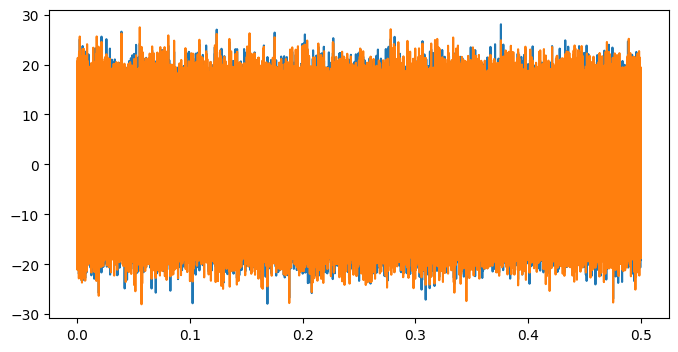

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, msk_data, label='Noisy')
ax.plot(t, msk_clean, label='Cleaned')

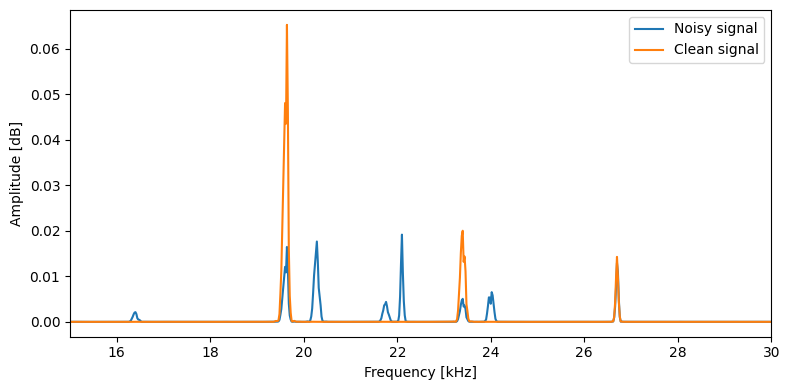

In [16]:
f, pxx_noise = signal.welch(msk_data, fs, nperseg=len(msk_data)/10) 
f, pxx_clean = signal.welch(msk_clean, fs, nperseg=len(msk_clean)/10)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(f/1e3, (pxx_noise), label='Noisy signal')
ax.plot(f/1e3, (pxx_clean), label='Clean signal')


ax.set_ylabel('Amplitude [dB]')
ax.set_xlabel('Frequency [kHz]')
ax.set_xlim(15, 30)
ax.legend(loc='upper right')
plt.tight_layout()

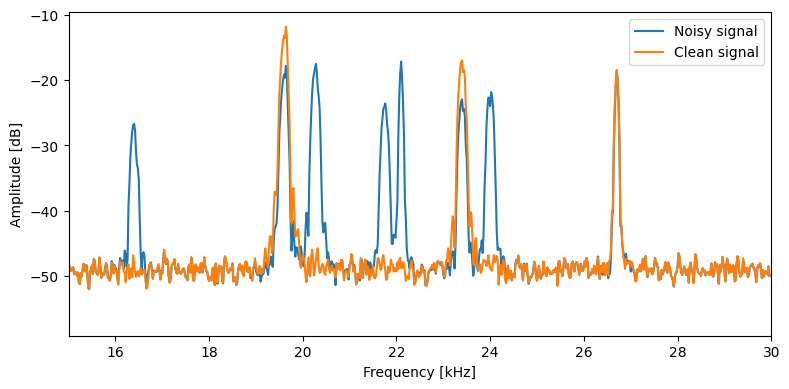

In [17]:
f, pxx_noise = signal.welch(msk_data, fs, nperseg=len(msk_data)/10) 
f, pxx_clean = signal.welch(msk_clean, fs, nperseg=len(msk_clean)/10)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(f/1e3, 10*np.log10(pxx_noise), label='Noisy signal')
ax.plot(f/1e3, 10*np.log10(pxx_clean), label='Clean signal')


ax.set_ylabel('Amplitude [dB]')
ax.set_xlabel('Frequency [kHz]')
ax.set_xlim(15, 30)
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('figures/analysis/Cleaned_signal.pdf')


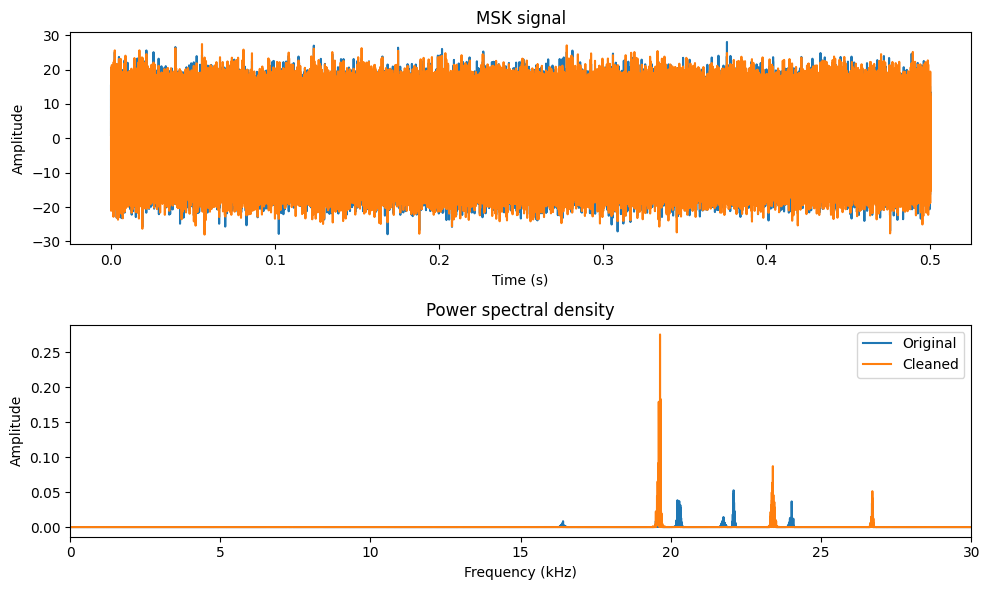

In [18]:
# calculate fft
f, fft_msk_clean = signal.periodogram(msk_clean, fs, nfft=len(msk_clean))

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot(t, msk_data, label='Original')
axs[0].plot(t, msk_clean, label='Cleaned')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('MSK signal')

#axs[1].plot(f/1e3, fft_msk_clean, label='Cleaned')#10*np.log10(Pxx))
axs[1].plot(f/1e3, (fft_msk_data), label='Original')#10*np.log10(Pxx))
axs[1].plot(f/1e3, (fft_msk_clean), label='Cleaned')#10*np.log10(Pxx))

axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Frequency (kHz)')
axs[1].set_title('Power spectral density')
axs[1].set_xlim(0, 30)
#axs[1].set_ylim(-100, 0)
plt.legend(loc='upper right')
plt.tight_layout()

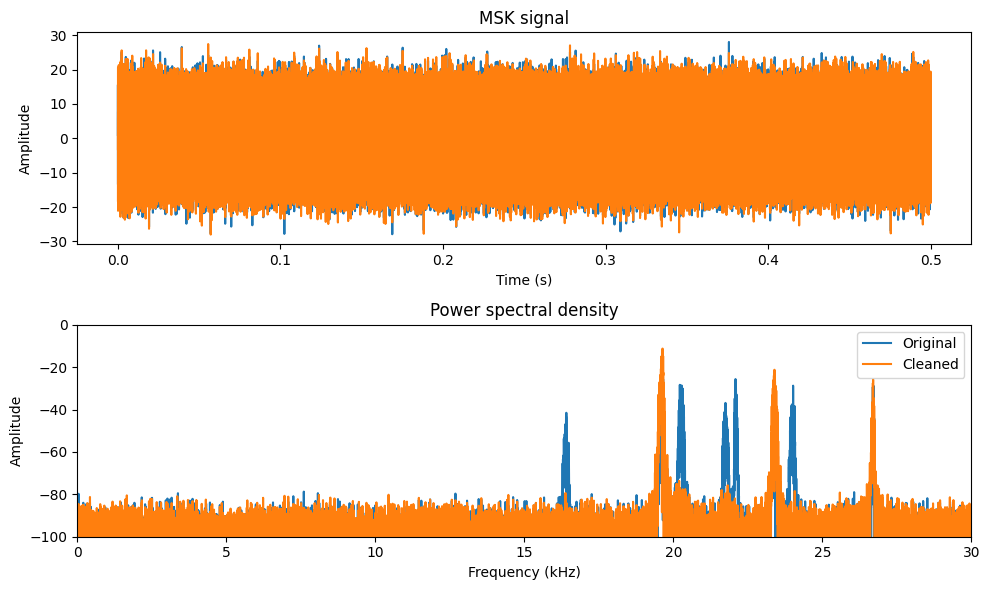

In [19]:
# calculate fft
f, fft_msk_clean = signal.periodogram(msk_clean, fs, nfft=len(msk_clean))

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot(t, msk_data, label='Original')
axs[0].plot(t, msk_clean, label='Cleaned')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('MSK signal')

#axs[1].plot(f/1e3, fft_msk_clean, label='Cleaned')#10*np.log10(Pxx))
#axs[1].plot(f/1e3, (fft_msk_data), label='Original')#10*np.log10(Pxx))
#axs[1].plot(f/1e3, (fft_msk_clean), label='Cleaned')#10*np.log10(Pxx))
axs[1].plot(f/1e3, 20*np.log10(fft_msk_data), label='Original')#10*np.log10(Pxx))
axs[1].plot(f/1e3, 20*np.log10(fft_msk_clean), label='Cleaned')#10*np.log10(Pxx))
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Frequency (kHz)')
axs[1].set_title('Power spectral density')
axs[1].set_xlim(0, 30)
axs[1].set_ylim(-100, 0)
plt.legend(loc='upper right')
plt.tight_layout()


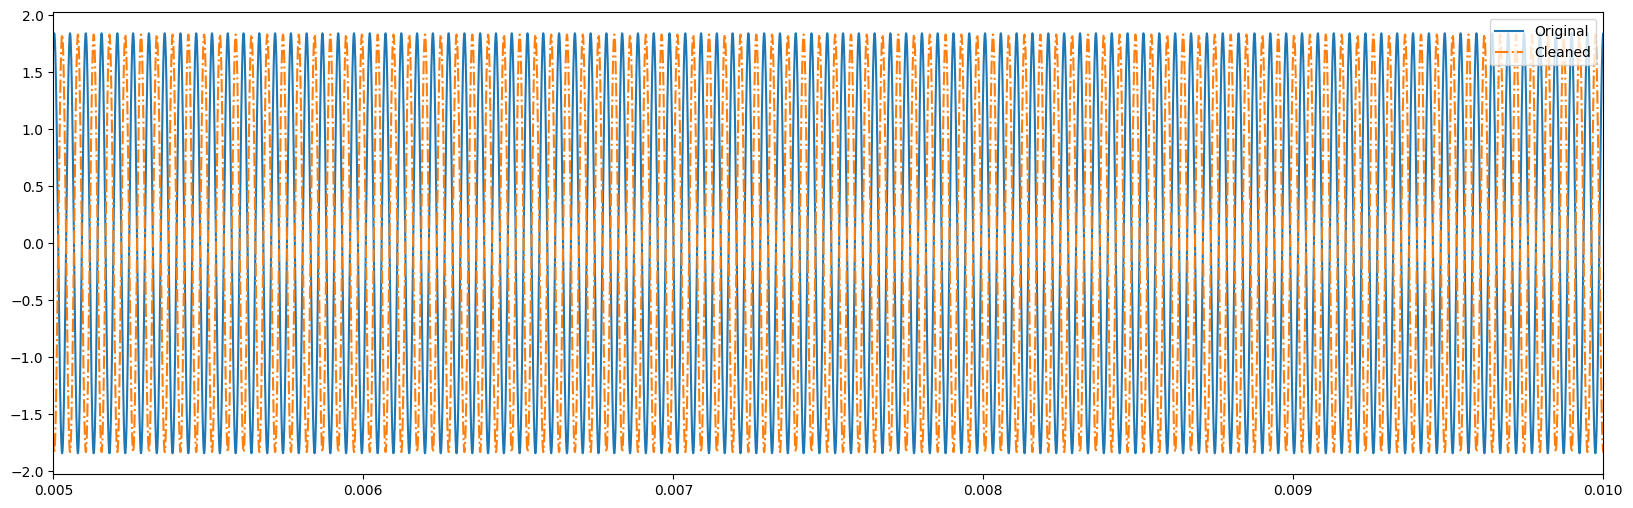

In [20]:
i_test = 1
s_test, t, _ = generate_msk_data(decoded_bits[i_test,0:int(time/T_symbols[i_test])], T_symbols[i_test], carriers[i_test], fs, offset=tau_hat[i_test], phase_offset=theta_hat[i_test], amplitude=a_hat[i_test])#, start_phase=phase_starts[i_test])
#s_test, t, _ = generate_msk_data(decoded_bits[i_test,0:int(time/T_symbols[i_test])], T_symbols[i_test], carriers[i_test], fs, offset=offset[i_test], phase_offset=phase_offset[i_test])
plt.figure(figsize=(20, 6))
plt.plot(t, msk_data_single[i_test], label='Original')
plt.plot(t, s_test, ls='-.', label='Cleaned')
plt.xlim(1/200*1, 2*1/200)
plt.legend(loc='upper right')